## Matrix factorization

We want to minimize
$$\min_X f(X)=f(U,V):=\frac 1 2 \|U V^\top - A\|^2_F,$$
where  $A\in {\mathbb R}^{m\times n}$, $U\in {\mathbb R}^{m\times r}$, $V\in {\mathbb R}^{n\times r}$ and $r<\min\{m,n\}$.
The gradient is given by $\nabla f(X) = [(UV^\top -A) V^\top, (UV^\top-A)^\top U]^\top$.

This is a nonconvex problem, moreover due to the product $UV^\top$, the gradient $\nabla f$ is not globally Lipschitz (but locally is).

For this experiment we used [Movielens 100K dataset](https://grouplens.org/datasets/movielens/100k/). In particular, we used the file `u.data` from that archive.



In [1]:
import numpy as np
import scipy.linalg as LA
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from algorithms import *


%load_ext autoreload
%autoreload 2

We load the dataset and write all data to the sparse matrix $A$. This matrix will collect movie ratings from $943$ users on $1682$ movies.

In [2]:
# Load data from disk
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('datasets/u.data', sep='\t', names=names)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

# Create r_{ui}, our ratings matrix
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

A = ratings
m, n = A.shape
print("The dimensions of A are:", m, n)

The dimensions of A are: 943 1682


In [3]:
# Choose the value for r (10, 20, 30)

r = 20

def f(X):
    U, V = X[:m], X[m:]
    return 0.5* LA.norm(U @ V.T - A)**2

def df(X):
    U, V = X[:m], X[m:]
    res = U @ V.T - A
    grad_U = res @ V
    grad_V = res.T @ U
    return np.vstack([grad_U, grad_V])


# evaluation function.
J = lambda x: LA.norm(x)

# the starting point 
np.random.seed(0)
X0 = np.random.randn(m + n, r)



Notice that in order to run GD or AGD, we require manually to tune a stepsize $1/L$. We found it by many rounds of trial and errors. Interestingly, both these methods converge with different steps, and they both diverge if one takes in two times larger steps respectively.

GD doesn't work with L = 500, but works with L = 1000

AGD works with L = 30000, doesn't work even with L = 20000 (after approximately 2000 iteration starts to diverge)




In [4]:
# gradient descent
N = 70000
L = 1000
ans1 = gd(J, df, X0, 1./L, numb_iter=N)


Time execution for GD: 309.218368198


Check that it doesn't work with L=500

In [9]:
# checking that smaller step will not work for GD
# you can skip it
N = 1000
L = 500
try:
    ans1_not = gd(J, df, X0, 1./L, numb_iter=N)
except Exception as e:
    print(e)

array must not contain infs or NaNs


/Users/mishchk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in matmul
  if sys.path[0] == '':
/Users/mishchk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in matmul
  del sys.path[0]


In [6]:
# Nesterov accelerated gradient descent
N = 70000
L = 30000
ans2 = accel_gd(J, df, X0, 1./L, numb_iter=N)


Time execution for accelerated GD: 344.2011235870002


In [13]:
# checking that smaller step will not work for acceleretaed GD
# you can skip it
N = 10000
L = 15000
try:
    ans2_not = accel_gd(J, df, X0, 1./L, numb_iter=N)
except Exception as e:
    print(e)

array must not contain infs or NaNs


/Users/mishchk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in matmul
  if sys.path[0] == '':
/Users/mishchk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in matmul
  del sys.path[0]


In [7]:
# adaptive GD
N = 70000
ans3 = ad_grad(J, df, X0, 1e-9, numb_iter=N)

Time execution of adaptive gradient descent: 299.878739926


In [20]:
# adaptive acelerated GD (heuristic)
N = 70000
ans5 = ad_grad_accel(J, df, X0, 1e-9, numb_iter=N)

Time execution of adaptive gradient descent: 340.3383180159999


Make the plots

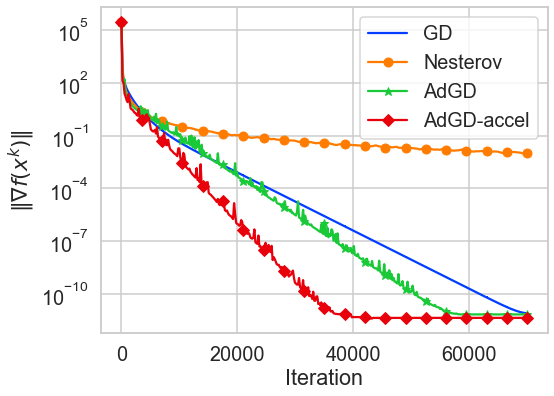

In [21]:
sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)


answers = [ans1, ans2, ans3, ans5]
values = [ans[0] for ans in answers]
labels = ["GD", "Nesterov", "AdGD", "AdGD-accel"]
markers = [',', 'o', '*',  'D']
colors = [(0.00784313725490196, 0.24313725490196078, 1.0), 
          (1.0, 0.48627450980392156, 0.0), 
          (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
          (0.9098039215686274, 0.0, 0.043137254901960784),
          (0.5450980392156862, 0.16862745098039217, 0.8862745098039215), 
          (0.6235294117647059, 0.2823529411764706, 0.0), 
          (0.9450980392156862, 0.2980392156862745, 0.7568627450980392), 
          (0.6392156862745098, 0.6392156862745098, 0.6392156862745098), 
          (1.0, 0.7686274509803922, 0.0), (0.0, 0.8431372549019608, 1.0)]

n_plot = 400
plt.figure(figsize=(8,6))
for i, val in enumerate(values):
    skip = len(val) // n_plot
    plt.plot(
        np.arange(0, len(val), skip), 
        val[::skip], label=labels[i], color=colors[i],
        marker=markers[i], markevery=20)
    
plt.yscale('log')
plt.xlabel(u'Iteration')
plt.ylabel(r'$\Vert \nabla f(x^k)\Vert$')
plt.legend()
#plt.savefig('../plots/for_paper/factorization={}.pdf'.format(r), bbox_inches='tight', dpi=300)


Save all data points

In [18]:
np.save('saved_data/factorization-{}.npy'.format(r), np.vstack([ans[0] for ans in answers]))  